# Model Test
This notebook is a first model approach to determine if a model can be adjusted correctly to the data. 

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import shap
import seaborn as sns
import warnings
import shap

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # Model to use, may change

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Constants

In [2]:
data_path = "../data/interim/interim.parquet"
warnings.filterwarnings("ignore")
random_seed_nb = 42

# Read data
Dataset is organized as follows:
- product1_id: fdc_id_x, this is the product 1
- product2_id: fdc_id_to, this is the product 2
- similarity: similar, This is the target, which measures the similarity between foods. 
- characteristic_vector1: Information of product 1
- characteristic_vector2: Information of product 1

Each characteristic vector contains all the nutritional information, the product description and the ingredients. 

Data contains 5586094 rows. 

In [3]:
all_data = pd.read_parquet(data_path)

In [4]:
#all_data.head()
#all_data[[v for v in all_data.columns if "_x" in v]].notna().mean().head(50)

In [5]:
# Ciertas columnas no son necesarias para realizar una predicción, 
# vamos a deshecharlas por ahora. 
non_predictor_columns = [
    "fdc_id_to", 
    "similar", 
    "product_description_x",
    "product_description_y", 
    "ingredients_x",
    "ingredients_y",
]

id_colums = ["fdc_id_x", "fdc_id_y"]

# En cada característica (columna), tenemos valores nutricionales tanto del 
# primer product (producto x) como del segundo producto (producto y)
predictors = all_data.drop(non_predictor_columns, axis=1) 
target = all_data.similar # Utilizamos la columna 'similar' como variable de respuesta

# Test-train split

In [6]:
train_index, test_index = train_test_split(
    predictors['fdc_id_x'].unique(), 
    train_size=0.7, 
    random_state=random_seed_nb
)

# Queremos que lo que vea el modelo para entrenar NO esté de 
# ninguna manera en el conjunto de pruebas.
real_train_index = predictors[
    (predictors['fdc_id_x'].isin(train_index)) & 
    (~predictors['fdc_id_y'].isin(test_index))
].index

# Queremos también que lo que vea el modelo para evaluar NO esté 
# de ninguna manera incluido en el conjunto de entrenamiento.
real_test_index = predictors[
    (predictors['fdc_id_x'].isin(test_index)) &
    (~predictors['fdc_id_y'].isin(train_index))
].index

In [7]:
# Esperaríamos que no hubiese intersección entre los productos
# que están en el train set y en el test set
set(predictors.loc[real_test_index].fdc_id_x.unique()).intersection(
    set(predictors.loc[real_train_index].fdc_id_x.unique()))

set()

In [8]:
# En este caso suplantamos nulos con un valor negativo. 
x_train = predictors.loc[real_train_index].drop(id_colums, axis=1).fillna(-100)
y_train = target.loc[real_train_index]

x_test = predictors.loc[real_test_index].drop(id_colums, axis=1).fillna(-100)
y_test = target.loc[real_test_index]

In [9]:
# x_train.head()

In [10]:
# x_test.head()

#  Save the datasets and the data-indexes. 

In [11]:
# Salvemos los conjuntos de datos para predecir y para evaluar

# train
x_train.to_parquet("../data/processed/x_train.parquet")
pd.DataFrame(y_train).to_parquet("../data/processed/y_train.parquet")

# test
x_test.to_parquet("../data/processed/x_test.parquet")
pd.DataFrame(y_test).to_parquet("../data/processed/y_test.parquet")

In [12]:
# Ahora salvamos los indices para lograr identificar qué productos pertenecen a qué conjunto de datos. 
with open("../data/processed/train_index.pkl", "wb") as train_index_pkl:
    pickle.dump(real_train_index, train_index_pkl)
with open("../data/processed/test_index.pkl", "wb") as test_index_pkl:
    pickle.dump(real_test_index, test_index_pkl)

# Create and Save model

In [13]:
# We check if the model path already exist, if it does not, we can train a new model. 
model_path = "../models/first_model.pkl"
if os.path.exists(model_path):
    with open(model_path, 'rb') as m:
        model2 = pickle.load(m)
else:
    model = RandomForestClassifier()
    model.fit(x_train, y_train)

In [14]:
with open(model_path, "wb") as file:
    pickle.dump(model, file)

# Evaluate results

In [15]:
pred = model.predict_proba(x_test)[:, 1]

In [16]:
results = pd.DataFrame()
results['pred'] = pred
results.set_index(x_test.index, inplace=True)
results['similar'] = y_test

In [17]:
roc_auc_score(y_test, pred)

0.9495118695075344

In [18]:
average_precision_score(y_test, pred)

0.6497049550675033

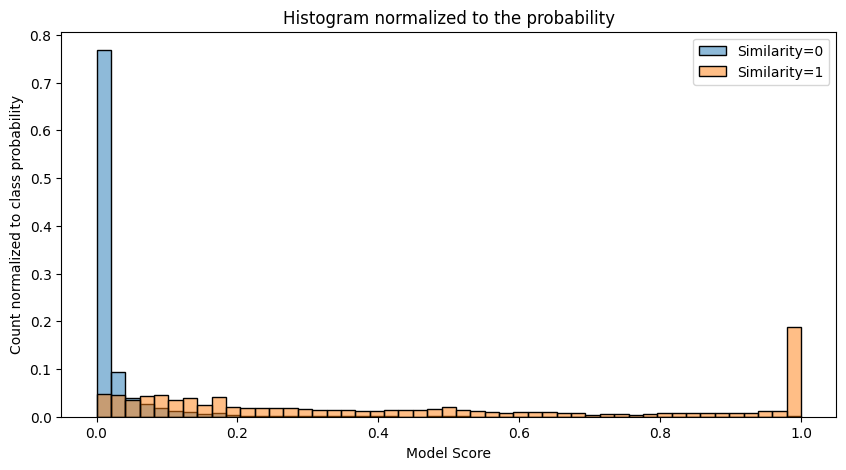

In [19]:

steps = 25
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(pred[y_test==0], bins=np.linspace(0,1,50), stat="probability", alpha=0.5, label='Similarity=0')
sns.histplot(pred[y_test==1], bins=np.linspace(0,1,50), stat="probability", alpha=0.5, label='Similarity=1')
plt.legend()
plt.title("Histogram normalized to the probability")
plt.xlabel("Model Score")
plt.ylabel("Count normalized to class probability")
plt.show()

In [20]:
results['bins'] = pd.cut(results.pred, bins=np.linspace(0,1,steps))

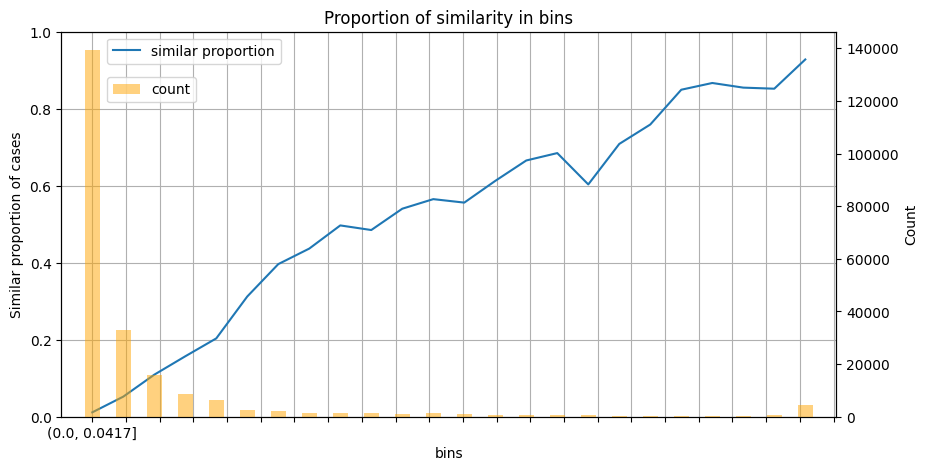

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
results.groupby("bins").similar.mean().plot(ax=ax, label='similar proportion')
ax.set_title("Proportion of similarity in bins")
ax.set_ylim(0,1)
ax.grid()
ax2 = plt.twinx(ax)
results.groupby('bins').similar.count().plot(ax=ax2, kind='bar', color='orange', alpha=0.5, label='count')
ax.set_xticks(np.linspace(0,steps,steps-1))
ax2.set_xlim(-1,steps-1)
ax2.set_ylabel('Count')
ax.set_ylabel('Similar proportion of cases')
ax.legend(loc='upper left', bbox_to_anchor=(0.05, 1.0))
ax2.legend(loc='upper left', bbox_to_anchor=(0.05, 0.9))

plt.show()

In [22]:
all_data.loc[
    results[
        (results.pred > 0.8) & (results.similar==0)
    ].sample(20).index
][['product_description_x', 'product_description_y', 'similar']]

,product_description_x,product_description_y,similar
3344009,"Chicken leg, drumstick and thigh, fried, coate...","Chicken, NS as to part and cooking method, ski...",0
2026599,"Green beans, frozen, cooked with oil","Artichoke, canned, cooked, no added fat",0
2028962,"Green beans, frozen, cooked with butter or mar...","Artichokes, NS as to form, cooked",0
1400883,"Chicken thigh, NS as to cooking method, skin e...","Chicken, NS as to part, baked, coated, skin / ...",0
2026563,"Broccoli, fresh, cooked, no added fat","Artichoke, canned, cooked, no added fat",0
653795,"Bread, whole grain white, toasted","Muffin, English, whole grain white",0
5268882,"Potato sticks, fry shaped","Tortilla chips, reduced sodium",0
5101469,"Roll, white, soft","Bread, sprouted wheat, toasted",0
420656,"Bread, sprouted wheat, toasted","Bread, onion",0
501523,"Bread, Italian, Grecian, Armenian, toasted","Bread, multigrain, reduced calorie and/or high...",0


In [23]:
all_data.loc[results[(results.pred < 0.01) & (results.similar==1)].sample(20).index][['product_description_x', 'product_description_y', 'similar']]

,product_description_x,product_description_y,similar
1964772,"Carrots, cooked, from restaurant","Mustard greens, canned, cooked, no added fat",1
728961,"Butter-oil blend, stick","Butter-oil blend, NFS",1
1317492,"Turkey, light meat, roasted, skin eaten","Chicken breast, baked or broiled, skin eaten, ...",1
4119797,"Egg, whole, cooked, NS as to cooking method","Egg omelet or scrambled egg, with tomatoes and...",1
1917538,"Carrots, glazed, cooked","Spinach, NS as to form, cooked",1
2545964,"Biscuit, NFS","Cookie, vanilla sandwich, extra filling",1
2335746,"Biscuit, NFS","Crackers, wheat, reduced fat",1
3028183,"Summer squash, yellow or green, fresh, cooked ...","Greens, frozen, cooked, no added fat",1
1945951,"Bean sprouts, cooked","Collards, canned, cooked with butter or margarine",1
278816,"Pinto beans, NFS",Baked beans from fast food / restaurant,1


In [24]:
x_train_sample = x_train.sample(100, random_state=random_seed_nb)

In [25]:
x_train_sample_similar = x_train_sample.loc[
    all_data[
        (all_data.index.isin(x_train_sample.index)) & 
        (all_data.similar==1)
    ].index
]

In [26]:
explainer = shap.TreeExplainer(model)
shap_values_similar = explainer.shap_values(x_train_sample_similar)

In [27]:
#shap_values_explainer = explainer(x_train_sample)

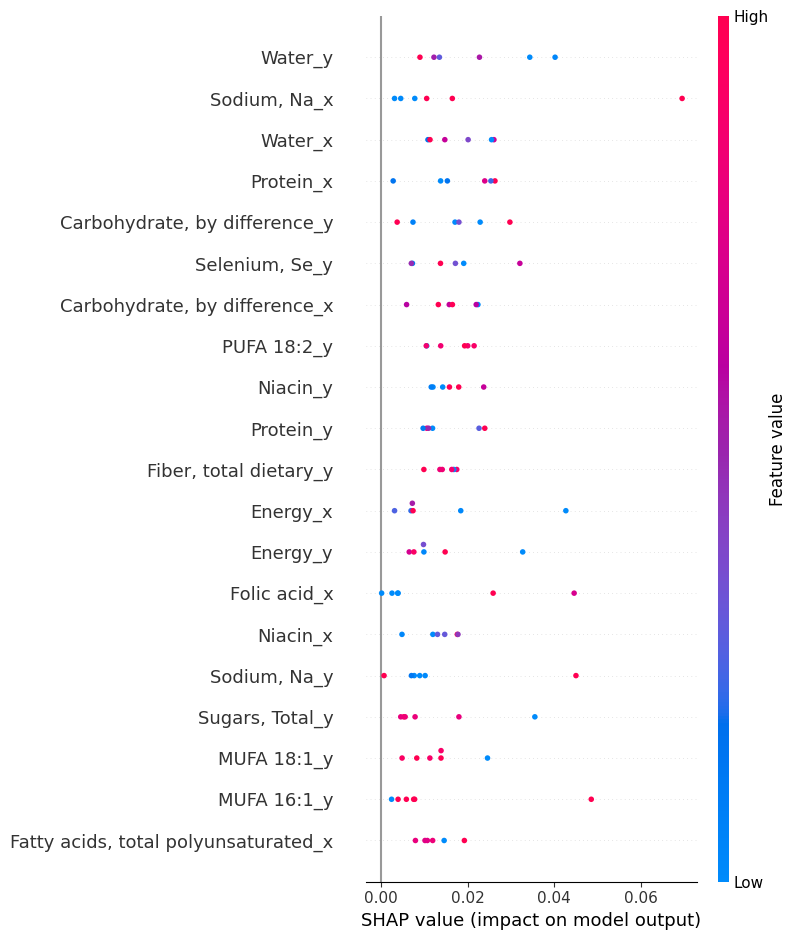

In [28]:
shap.summary_plot(shap_values_similar[1], x_train_sample_similar)